# スケルトンの自動抽出  合成画像で検証

面積は 148067.0


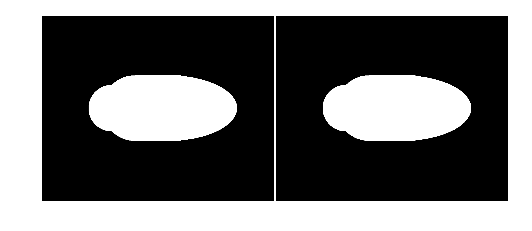

In [14]:
import radishlib as rdl

%matplotlib inline
# %matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt
from copy import copy
import cv2

# 表示のオンオフ
IMGON = True

# 処理対象画像
imgfile = 'pics/horyou2c6k.jpg'

# 表示のオンオフ
IMGON = True

# 画像の読み込み
# src = cv2.imread(imgfile,0)
# ２階調化
#bw = rdl.dthreshold(src)
# 最大白領域の取り出し
# bw = rdl.getBigWhite(bw)

# ダミー画像の生成
dd = int(np.sqrt(2)*100)
dummy =  np.zeros((800,1000),dtype=np.uint8)
dummy = cv2.circle(dummy,(300,400), 100, (255,255,255), -1)
dummy = cv2.circle(dummy,(400,400), dd,  (255,255,255), -1)
dummy = cv2.rectangle(dummy,(400,400-dd),(600,400+dd),  (255,255,255), -1)
dummy = cv2.ellipse(dummy,(400+dd,400),(300,dd),0,0,360,(255,255,255), -1)

src = dummy
bw = dummy

rdl.paraimage(src,bw)



print("面積は", rdl.countWhitePixels(bw))

（注意）　２値化関数 dthreshold のしきい値のデフォルトは７０。小領域の雑音除去もデフォルトで実行する。
画像によってはしきい値７０を変えないといけない場合がある。

getBigWhite で最大の白領域を取り出しているので、もし最大領域が目的の領域でない場合は getBigWhite の定義式の１を変えればよい。


# 余白除去


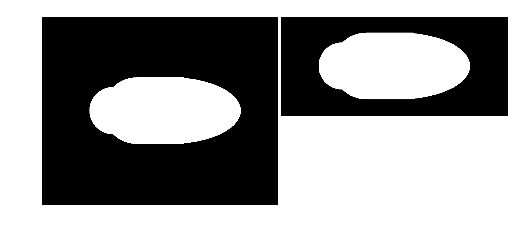

In [2]:
#  使用例
# グレイ画像の場合，もしくは結果をグレー化したい場合
cutimg = rdl.cutmargin(bw, ratio=4, showline=False, color=(255,0,0),bsize=6)   
rdl.paraimage(bw,cutimg)

# 直線当てはめにより回転角を自動決定して回転

True

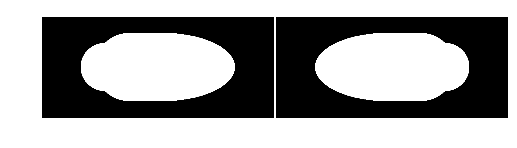

In [3]:
daikonimg = rdl.rotateAndcut(cutimg,ratio=4)
rdl.paraimage(cutimg, daikonimg)
cv2.imwrite("pics/horyou2c6kR.jpg",daikonimg)

# 距離画像生成
各白画素に対して、その画素から最も近い黒画素までの距離を求める。
距離を明るさに対応させた画像を距離画像とよぶ

最大距離の画像位置(x,y) = ( 417 , 211 ),  maxR=  142.0


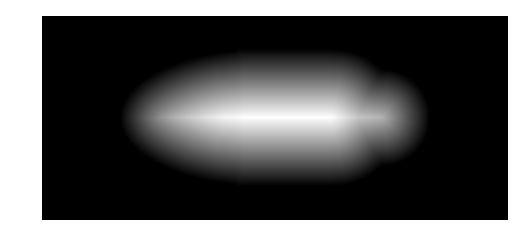

In [4]:
# 距離画像変換　　各白画素について，最も近い黒画素までの距離をデータとする画像を生成
dist = cv2.distanceTransform(daikonimg,cv2.DIST_L2,5)

# 最大の距離は？　　　これが最大半径となる
maxR = np.max(dist)
maxPn = np.argmax(dist)   # 2次元配列に対して argmax を取ると、1次元に並べたと仮定したときの番号が返ってくる
maxY = int(maxPn/dist.shape[1])
maxX = maxPn - maxY*dist.shape[1]
print("最大距離の画像位置(x,y) = (",maxX, ",",maxY,"),  maxR= ", maxR)

# 最大値が白（最大輝度）になるようダイナミックレンジの拡大をしてみる
distimg = ((dist/maxR)*255).astype('uint8')
rdl.plotimg(distimg)

# 輪郭線追跡

周囲長= 1432


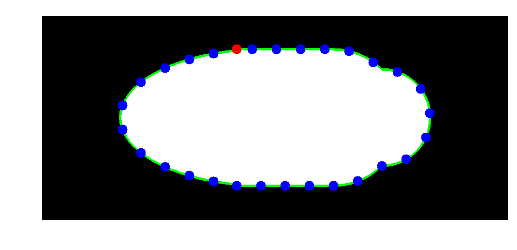

In [5]:
# 輪郭線の抽出
bw,pts = rdl.getContour(daikonimg,0)
xdata = [i[0][0]  for i in ｐｔｓ[0]]
ydata = [i[0][1]  for i in pts[0]]   

# 輪郭データの重複を取り除く
pts =  []
for i in range(len(xdata)):
    if [xdata[i],ydata[i]] not in pts:
        pts.append([xdata[i],ydata[i]] )
cpts = np.array(pts)
print("周囲長=",len(cpts))

# plt.gca().set_aspect('equal',adjustable='box')
# plt.plot(cｐｔs[:,0],cpts[:,1],"r")
rdl.plotimg(rdl.drawRadishContour(daikonimg, cpts, dotsize=2,ldotsize=10,sdotsize=10,interval=50,flag=True))

# 輪郭線の曲率を求める

曲率計算のためのサンプル間距離は 14
ミディアンフィルタのサイズ 14
曲率最大の点は 275 番のサンプル点で、曲率は 0.0151041519755 座標は [161 211]


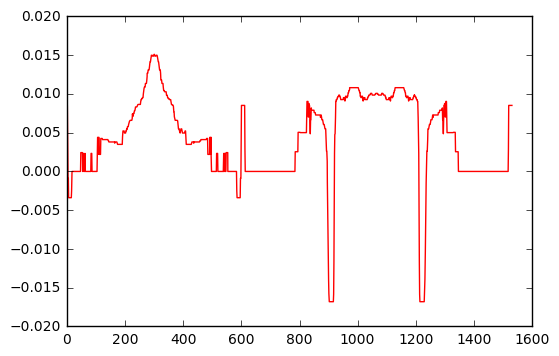

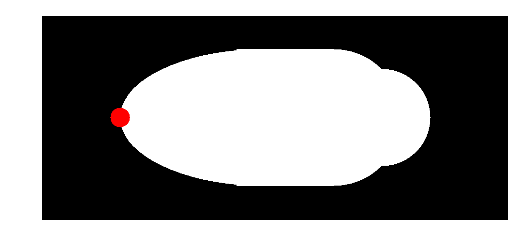

In [7]:
curvelength, cvs, tippoint = rdl.curvature(cpts,samplefactor=100,masklen=-1)

pimg = cv2.merge((daikonimg,daikonimg,daikonimg))
plt.plot(curvelength,cvs,"r")
plt.show()
rdl.plotimg(cv2.circle(pimg,tuple(tippoint),20,(0,0,255),-1))

## curvature(data, samplefactor, masklen)
<pre>
data  座標のリスト
　　　　　   np.array( [[x0,y0],[x1,y1],[x2,y2],...., ]]) という形式のデータ
samplefactor (整数値）
    　　　　各点の曲率は、その点P１とその両側のサンプル点P0,P1の３点を通る円の半径の逆数として求めている。
       この3点は近すぎるとデジタル画像の量子化誤差の影響を大きく受けるし、離しすぎると細かい変化が
       とらえられなくなるので、適度な距離に設定しないといけない。それをこのパラメータで調整する。
       各点に対して、この輪郭長を samplefactor で割った値だけ離れたサンプルが曲率算出に用いられる。
       例えば、輪郭長が５０００で samplefactor=100 ならば、前後５０サンプル分離れた点を用いるという意味。
masklen（整数値）
　　　　　　　　後処理として、得られた曲率データに対しメディアンフィルタをかけてノイズを除去する。
      その際に、前後いくつのデータを参照してノイズ除去を行うかを決めるパラメータ。
      　このパラメータで指定した数だけ前後のデータを取り出し、その中央値を実際のデータとして採用する。
       0 に設定すればノイズ除去は行われない。
       −１に設定すると、近似の際に用いたサンプル間隔が masklen として用いられる。</pre>
       
＃　参考 
- [点列から曲率、曲率半径を求める（FastCode）](http://sach1o.blog80.fc2.com/blog-entry-96.html)

![](http://blog-imgs-27.fc2.com/s/a/c/sach1o/discrete_curvature.gif)

# スケルトン追跡（曲率最大の点から稜線をトレース）

スケルトンの画素数 802.0


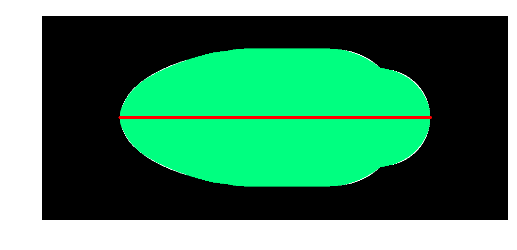

In [8]:
dist2 = copy(dist)
skel = np.array(rdl.traceRidges1(tippoint[0],tippoint[1],1,dist2))
skeldata = skel[skel[:,0].argsort()]    # この画像は大根が横向きなので，スケルトンを ｘの昇順に並べ替える
print("スケルトンの画素数",np.max(skeldata))
recallimg = rdl.skel2img2(skeldata,daikonimg)
rdl.plotimg(recallimg)

# スケルトン追跡（tradeRidges1）
### traceRidges1(sx, sy, direction, dist, [phaseswitch=5, para1=0.998])
<pre>
距離画像の稜線を追跡することで芯線を得る。

sx,sy   スケルトン追跡の開始点　　輪郭線の曲率最大の点を指定すれば良い
direction  初期追跡方向　　　
　　　　　　　5   6   7
       4   　　　   0　　　　　  右方向を０とし、時計回りに、１，２，３
       3   2   1
       
この例の場合、最初は右下方向、１を指定すればよい。

dist  距離画像データ
phaseswitch  追跡は基本的には距離１の点に到達したら終了するが開始点付近では１である可能性が高い。
　　　　　　　　　そこで、はじめこのパラメータで指定する値より距離値が大きくなるまでは距離１になっても追跡をやめず、
        追跡を続ける。
para1 斜め方向への移動は水平方向より移動距離が大きいので距離データの変化も大きいため、
　　　　　　　　　　割り引いて評価する。その割引率。
          
</pre>

### 返り値
[x 座標,  y座標, 距離データ]  が並んだ numpy配列が返ってくる.      

In [9]:
# この時点で、skel には  次のようなデータが入っている  （１０番目まで印刷）
print( skel[0:10])

[[ 161.  211.    1.]
 [ 162.  211.    2.]
 [ 163.  211.    3.]
 [ 164.  211.    4.]
 [ 165.  211.    5.]
 [ 166.  211.    6.]
 [ 167.  211.    7.]
 [ 168.  211.    8.]
 [ 169.  211.    9.]
 [ 170.  211.   10.]]


輪郭の曲率を求めるときに使った関数が個々でも使える。   curvature　の第１引数は [x,y]のリストなので、
すべての要素について、０番から１番までのデータを取り出して curvature の第１引数に渡せば良い。

skel[:,0:2]　　

という表現で、skel の各ベクトルの第1,第２要素だけ抽出できる。ためしに印刷してみると、

In [10]:
print(skel[:,0:2][0:10])

[[ 161.  211.]
 [ 162.  211.]
 [ 163.  211.]
 [ 164.  211.]
 [ 165.  211.]
 [ 166.  211.]
 [ 167.  211.]
 [ 168.  211.]
 [ 169.  211.]
 [ 170.  211.]]


# スケルトンの曲率関数

曲率計算のためのサンプル間距離は 6
ミディアンフィルタのサイズ 6
曲率最大の点は 0 番のサンプル点で、曲率は 0.0 座標は [ 167.  211.]


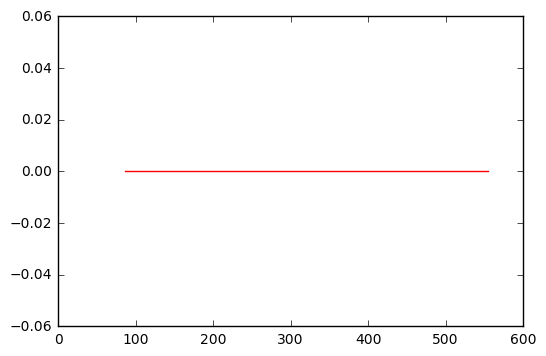

In [11]:
spts =  skel[:,0:2]
curvelength, cvs, tippoint = rdl.curvature(ｓｐｔｓ,samplefactor=100,masklen=-1, open = True)
xdata = curvelength[80:-80]
ydata = cvs[80:-80]
plt.plot(xdata,ydata,"r")


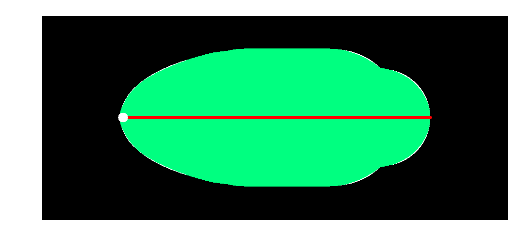

In [12]:
tmpimg = copy(recallimg)
point = (int(tippoint[0]),int(tippoint[1]))
rdl.plotimg(cv2.circle(tmpimg,point,10,(255,255,255),-1))

In [26]:
list(list(tippoint))

[911.0, 598.0]

In [39]:
xdata

array([   91.86168475,    92.86168475,    94.27589831, ...,  2516.58602653,
        2517.58602653,  2518.58602653])

In [42]:
cvs.shape

(2435,)

In [43]:
curvelength.shape

(2435,)